In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
import tensorflow as tf
tf.debugging.set_log_device_placement(False) 
import warnings
warnings.filterwarnings('ignore')

2024-05-04 05:58:52.415622: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-04 05:58:52.490656: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-04 05:58:52.778728: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 05:58:53.875400: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
tf.random.set_seed(42) 

In [4]:
forest=pd.read_csv('forestfires.csv')
forest.head()
#We can remove the seperate month columns as not needed

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small


In [5]:
df = forest.copy()
df.drop(df.columns[11:30],axis=1,inplace = True)

In [6]:
df.info()
#No null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  size_category  517 non-null    object 
dtypes: float64(8), int64(1), object(3)
memory usage: 48.6+ KB


In [7]:
df.size_category.value_counts()
#We can remove this bias with the help of SMOTE 

small    378
large    139
Name: size_category, dtype: int64

## Data Visualizations


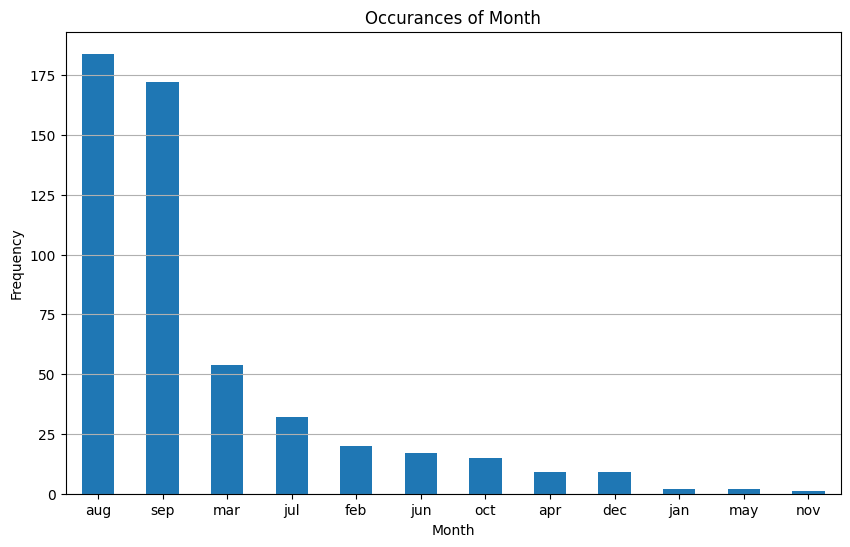

In [8]:
data=df.copy()

# Count occurrences of each month in the Month column

value_counts = data['month'].value_counts()

plt.figure(figsize=(10, 6))  
value_counts.plot(kind='bar')
plt.title('Occurances of Month')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability if needed
plt.grid(axis='y')  # Show grid lines along the y-axis
plt.show()

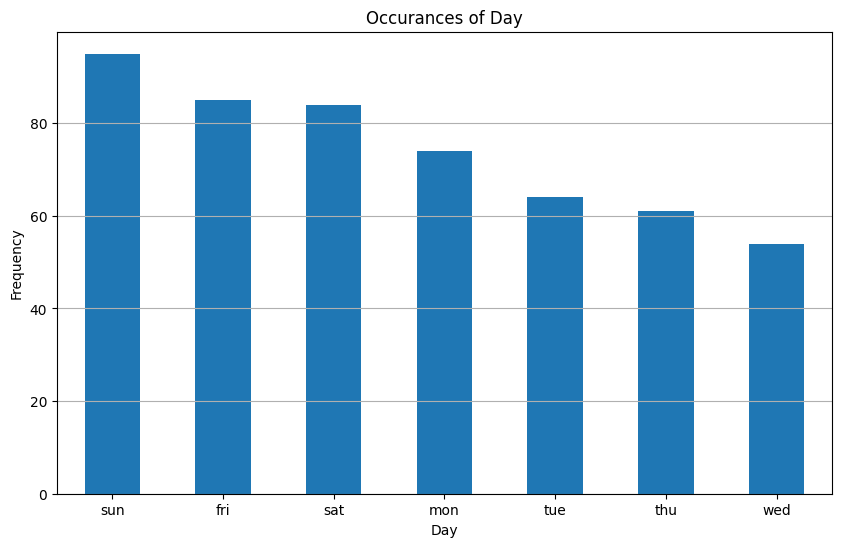

In [9]:
#Occurances of days

value_counts = data['day'].value_counts()

plt.figure(figsize=(10, 6))  
value_counts.plot(kind='bar')
plt.title('Occurances of Day')
plt.xlabel('Day')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability if needed
plt.grid(axis='y')  # Show grid lines along the y-axis
plt.show()

In [10]:
# Group by the Month column and aggregate other columns
Selected_columns=['month','FFMC','DMC','DC','ISI','temp','RH','wind','rain']
df_visual = pd.DataFrame({col: data[col] for col in Selected_columns})

grouped_data = df_visual.groupby('month').sum()

In [11]:
grouped_data 

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
month,,,,,,,,
apr,772.1,143.2,437.0,48.4,108.4,422,42.0,0.0
aug,16990.0,28286.8,117958.3,2037.3,3980.2,8370,751.9,10.8
dec,764.7,235.1,3161.2,31.2,40.7,346,68.8,0.0
feb,1658.1,189.5,1093.4,67.0,192.7,1114,75.1,0.0
jan,100.8,4.8,180.7,2.9,10.5,178,4.0,0.0
jul,2922.5,3532.4,14419.3,300.6,707.5,1444,119.5,0.2
jun,1520.3,1587.5,5061.0,200.2,348.4,767,70.3,0.0
mar,4830.0,1865.3,4100.9,383.8,706.5,2160,268.3,0.2
may,174.7,53.4,187.5,9.2,29.3,134,8.9,0.0


<Figure size 1000x600 with 0 Axes>

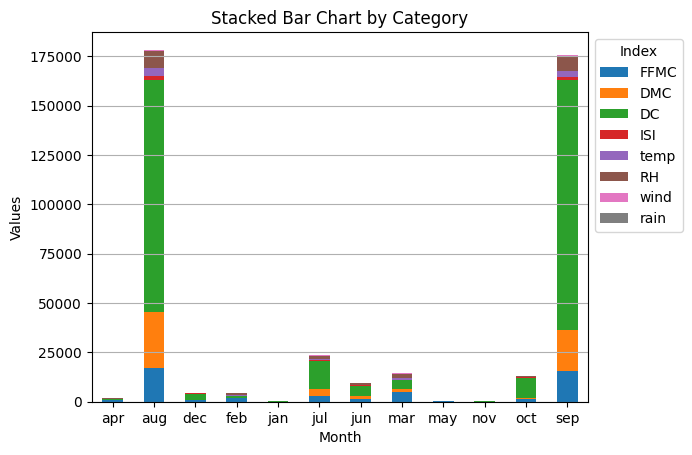

In [12]:
# Plot the grouped bar chart
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
grouped_data.plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart by Category')
plt.xlabel('Month')
plt.ylabel('Values')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability if needed
plt.legend(title='Index', bbox_to_anchor=(1, 1))  # Add a legend with column names
plt.grid(axis='y')  # Show grid lines along the y-axis
plt.show()

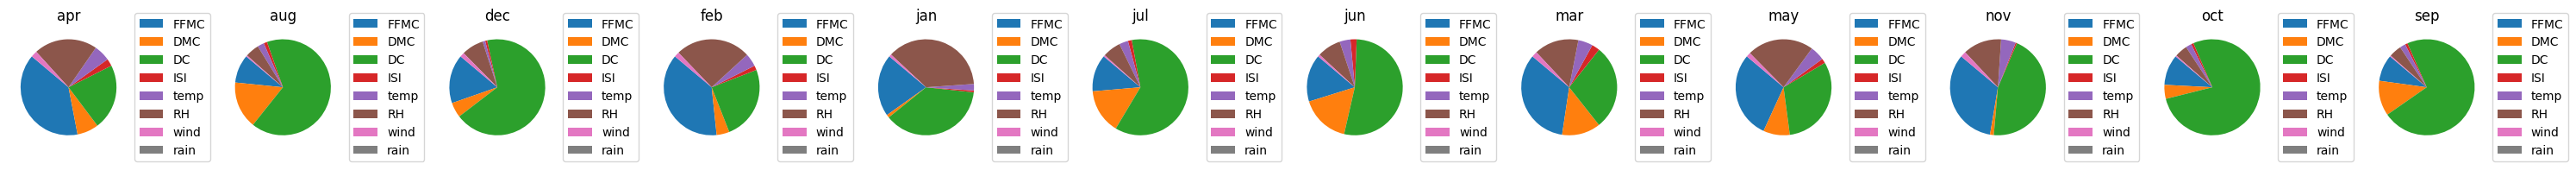

In [13]:
#Lets plot a pie chart for each Month to understand the situation Better

categories = grouped_data.index

# Plot pie charts
fig, axes = plt.subplots(nrows=1, ncols=len(categories), figsize=(30, 15))

for i, category in enumerate(categories):
    data_slice = grouped_data.loc[category]
    ax = axes[i] if len(categories) > 1 else axes
    pie = ax.pie(data_slice, labels=None, startangle=140)
    ax.set_title(category)
    ax.legend(data_slice.index, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

#### As we can observe for aug,dec,jul,jun,oct,sept we have DC of about 50% or above as compared to other months so that means that during these months we have high DC index where as in other months we have moderate to low DC index, Lowest DC index is seen in the month of april

#### FFMC index is mostly high for apr,feb,march,may and nov and Lowest in Aug,sept


## Lets check this on the basis of Day

In [14]:
# Group by the Month column and aggregate other columns
Selected_columns=['day','FFMC','DMC','DC','ISI','temp','RH','wind','rain']
df_visual = pd.DataFrame({col: data[col] for col in Selected_columns})

grouped_data = df_visual.groupby('day').sum()

<Figure size 2000x1000 with 0 Axes>

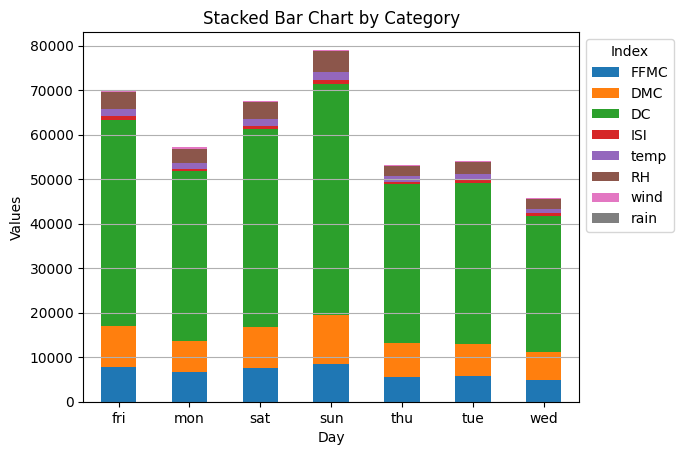

In [15]:
# Plot the grouped bar chart
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
grouped_data.plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart by Category')
plt.xlabel('Day')
plt.ylabel('Values')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability if needed
plt.legend(title='Index',bbox_to_anchor=(1, 1))  # Add a legend with column names
plt.grid(axis='y')  # Show grid lines along the y-axis
plt.show()


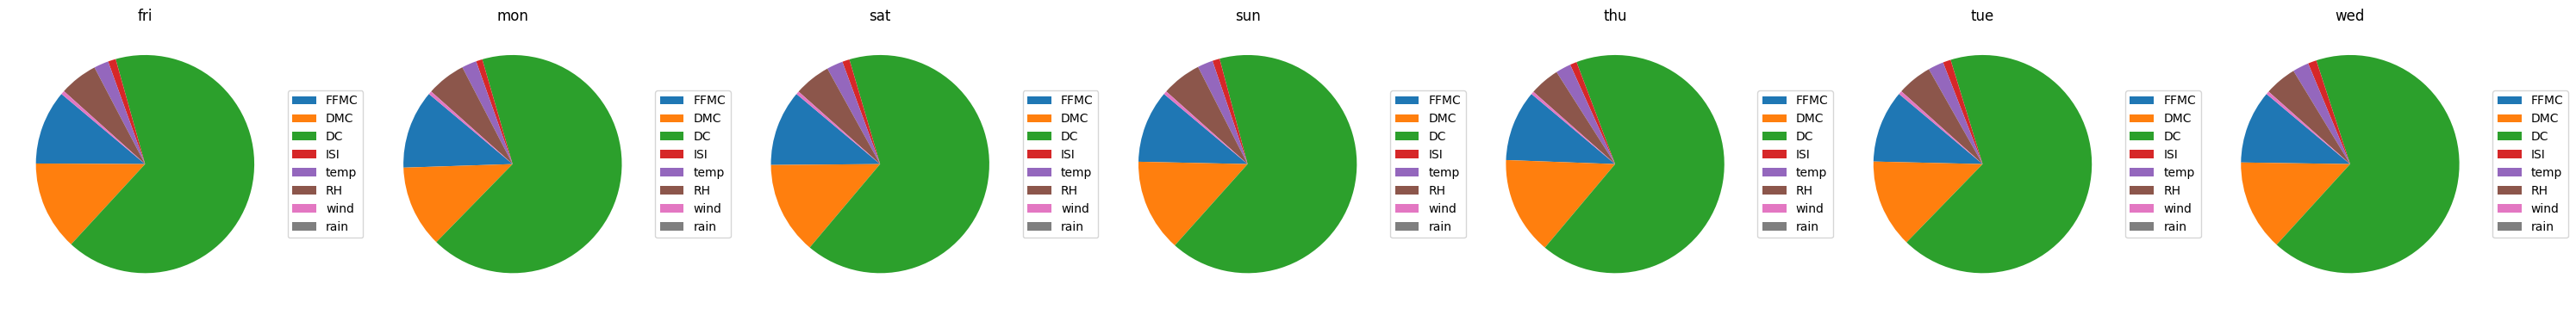

In [16]:
categories = grouped_data.index

# Plot pie charts
fig, axes = plt.subplots(nrows=1, ncols=len(categories), figsize=(30, 15))

for i, category in enumerate(categories):
    data_slice = grouped_data.loc[category]
    ax = axes[i] if len(categories) > 1 else axes
    pie = ax.pie(data_slice, labels=None, startangle=140)
    ax.set_title(category)
    ax.legend(data_slice.index, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

## Lets Check what % of area is covered on monthly and on the basis of day wrt large/small area

In [17]:
pd.options.mode.chained_assignment = None  #ignore warn


## correcting month order

month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
               'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

day_order = ['sun','mon','tue','wed','thu','fri','sat']# default='warn'

df_size = data[['month','day','area','size_category']]
df_size['month'] = pd.Categorical(df_size['month'], categories=month_order, ordered=True)
df_size['day'] = pd.Categorical(df_size['day'], categories=day_order, ordered=True)


grouped_data_month = df_size.groupby(['month','size_category','area'],observed=False).size()
grouped_data_day = df_size.groupby(['day','size_category'],observed=False).size()

## Burnt Area Count and Size wrt Day and Month

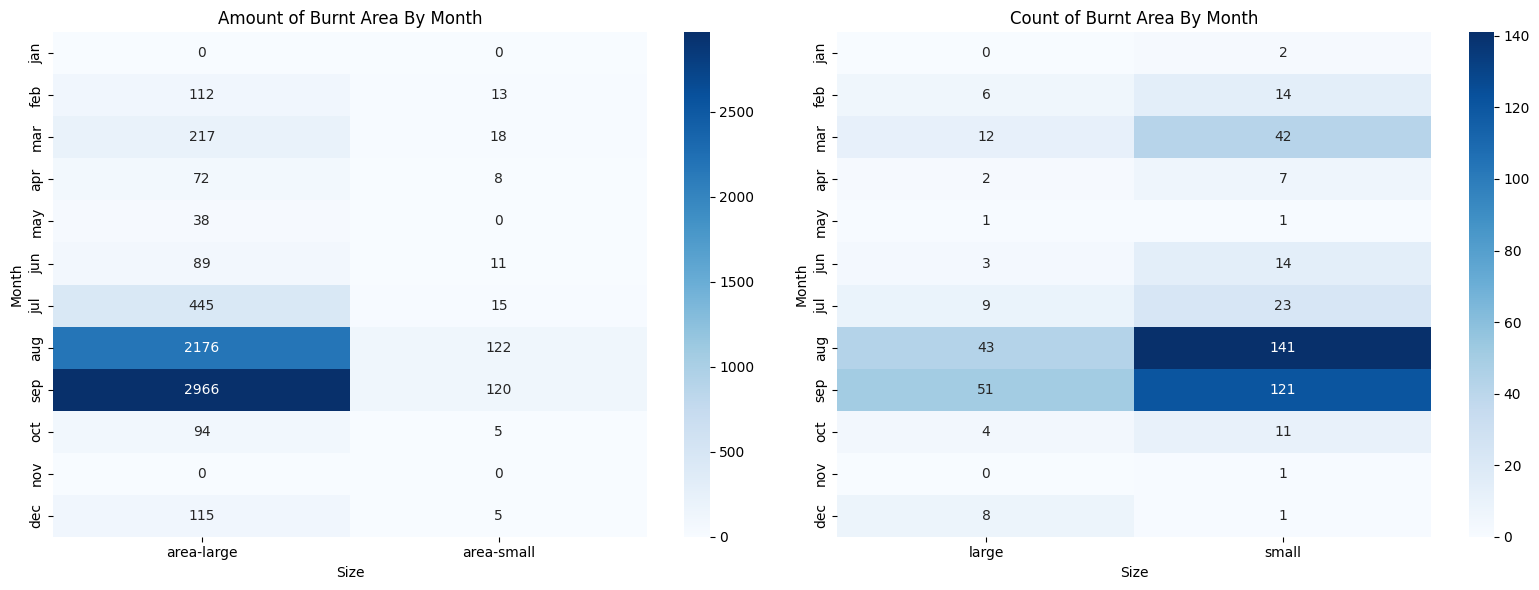

In [18]:
# Group by both 'month' and 'size_category' and sum the 'area' column
grouped_data_sum = df_size.groupby(['month', 'size_category']).agg({'area': 'sum'}).unstack(fill_value=0)

# Group by both 'month' and 'size_category' and count occurrences
grouped_data_count = df_size.groupby(['month', 'size_category']).size().unstack(fill_value=0)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot heatmap for summed 'area'
sns.heatmap(grouped_data_sum, annot=True, cmap='Blues', fmt='.0f', ax=axes[0])
axes[0].set_title('Amount of Burnt Area By Month')
axes[0].set_xlabel('Size')
axes[0].set_ylabel('Month')

# Plot heatmap for count of occurrences
sns.heatmap(grouped_data_count, annot=True, cmap='Blues', fmt='.0f', ax=axes[1])
axes[1].set_title('Count of Burnt Area By Month')
axes[1].set_xlabel('Size')
axes[1].set_ylabel('Month')

plt.tight_layout()
plt.show()


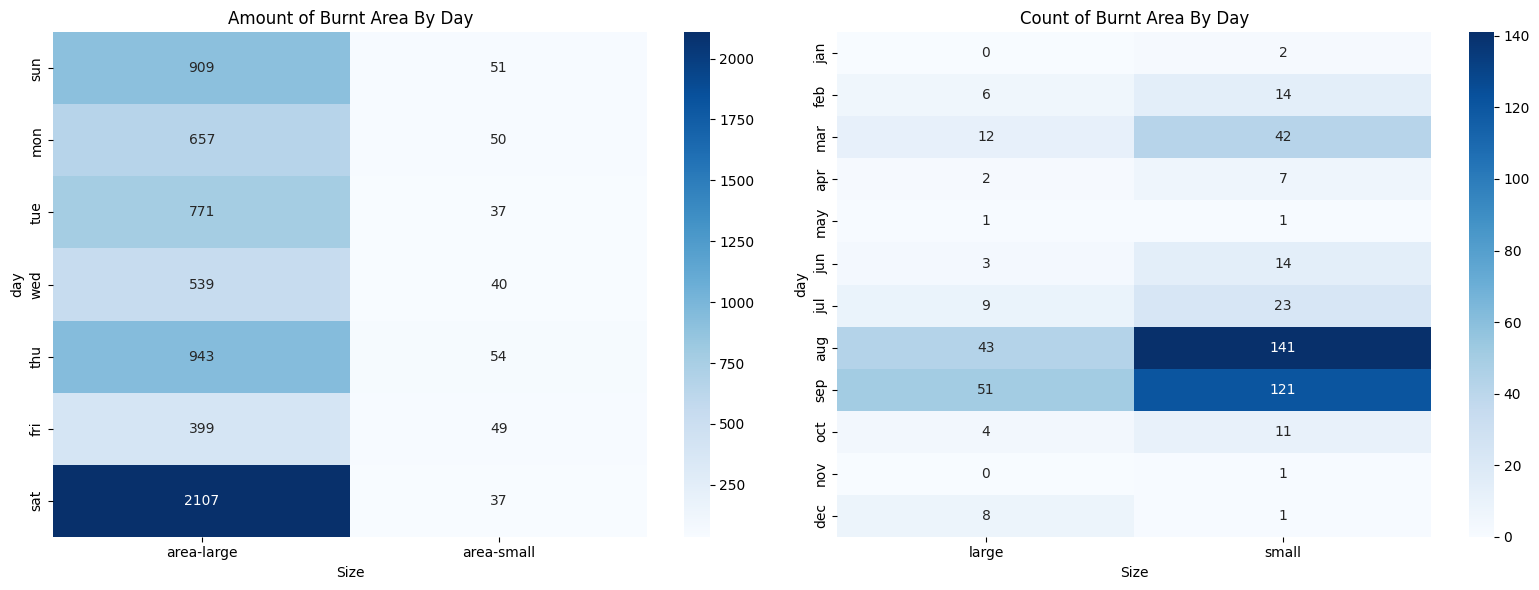

In [19]:
# Group by both 'Day' and 'size_category' and sum the 'area' column
grouped_data_sum = df_size.groupby(['day', 'size_category']).agg({'area': 'sum'}).unstack(fill_value=0)

# Group by both 'day' and 'size_category' and count occurrencesamt

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot heatmap for summed 'area'
sns.heatmap(grouped_data_sum, annot=True, cmap='Blues', fmt='.0f', ax=axes[0])
axes[0].set_title('Amount of Burnt Area By Day')
axes[0].set_xlabel('Size')
axes[0].set_ylabel('day')

# Plot heatmap for count of occurrences
sns.heatmap(grouped_data_count, annot=True, cmap='Blues', fmt='.0f', ax=axes[1])
axes[1].set_title('Count of Burnt Area By Day')
axes[1].set_xlabel('Size')
axes[1].set_ylabel('day')

plt.tight_layout()
plt.show()


## Data preprocessing and Standardization 

In [9]:
# Label Encoding

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df.month= label_encoder.fit_transform(df.month) 
df.day= label_encoder.fit_transform(df.day) 
df.size_category= label_encoder.fit_transform(df.size_category) 
df.head()


,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
0,7,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1
1,10,5,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,1
2,10,2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,1
3,7,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1
4,7,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,1


In [10]:
# SMOTE
from imblearn.combine import SMOTETomek
from collections import Counter

resamp = df.copy()

# SMOTEK TECHNIQUE

# Define dataset
a = resamp.iloc[:,:-1]
b = resamp.iloc[:,-1]

# Count before
print(Counter(b))

smt = SMOTETomek(sampling_strategy = 'auto')
a, b = smt.fit_resample(a, b)

# Count after
print(Counter(b)) #removed bias in dataset

Counter({1: 378, 0: 139})
Counter({1: 369, 0: 369})


In [11]:
# TRAIN TEST SPLIT

# Splitting the data into train and test
X = a
Y = b
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3)

In [12]:
# create model
model = Sequential()
model.add(Dense(14, input_dim=11, kernel_initializer='uniform', activation='relu'))
model.add(Dense(12,kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

In [14]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# Fit the model
hist = model.fit(X_train, y_train, validation_split=0.33, epochs=50, batch_size=10)



Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4916 - loss: 0.6930 - val_accuracy: 0.6901 - val_loss: 0.6836
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6412 - loss: 0.6818 - val_accuracy: 0.6257 - val_loss: 0.6585
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6577 - loss: 0.6490 - val_accuracy: 0.6608 - val_loss: 0.5990
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7864 - loss: 0.5828 - val_accuracy: 0.8246 - val_loss: 0.5043
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8338 - loss: 0.4901 - val_accuracy: 0.9240 - val_loss: 0.4186
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8945 - loss: 0.3963 - val_accuracy: 0.9415 - val_loss: 0.3237
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9163 - loss: 0.3071 - val_accuracy: 0.9357 - val_loss: 0.2429
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9254 - loss: 0.2407 - val_accuracy: 0.9415 - val_loss:

In [15]:
test_loss, test_acc = model.evaluate(X_test, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9982 - loss: 0.0195 


In [16]:
#Lets see if we can improve this by hypertuning


## Parameter Hypertuning

Batch Size and Epochs

In [18]:
from sklearn.model_selection import GridSearchCV, KFold
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from keras.optimizers import Adam

In [19]:
# create model
def create_model():
    model = Sequential()
    model.add(Dense(12, input_dim=8, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    
    adam=Adam(lr=0.01)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [20]:
from sklearn.preprocessing import StandardScaler
b= StandardScaler()
b.fit(X)
X_standardized = b.transform(X)

Learning Rate

In [28]:
from keras.layers import Dropout

# Defining the model
def create_model2(learning_rate,dropout_rate):
    model = Sequential()
    model.add(Dense(14,input_dim = 11,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(12,input_dim = 14,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,kernel_initializer='uniform',activation = 'sigmoid'))
    
    adam = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model


In [30]:
# Define the grid search parameters
learning_rate = [0.001,0.01,0.1]
dropout_rate = [0.0,0.1,0.2]

# Create the model
model2 = KerasClassifier(build_fn = create_model2,verbose = 0,batch_size = 20,epochs = 50)
# Make a dictionary of the grid search parameters
param_grids2 = dict(model__learning_rate = learning_rate,model__dropout_rate = dropout_rate)


In [31]:
# Build and fit the GridSearchCV
grid2 = GridSearchCV(estimator = model2,param_grid = param_grids2,cv = KFold(),verbose = 10)
grid_result2 = grid2.fit(X_standardized,Y)



Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START model__dropout_rate=0.0, model__learning_rate=0.001.........
[CV 1/5; 1/9] END model__dropout_rate=0.0, model__learning_rate=0.001;, score=0.993 total time=   2.2s
[CV 2/5; 1/9] START model__dropout_rate=0.0, model__learning_rate=0.001.........
[CV 2/5; 1/9] END model__dropout_rate=0.0, model__learning_rate=0.001;, score=0.993 total time=   2.2s
[CV 3/5; 1/9] START model__dropout_rate=0.0, model__learning_rate=0.001.........
[CV 3/5; 1/9] END model__dropout_rate=0.0, model__learning_rate=0.001;, score=0.953 total time=   2.3s
[CV 4/5; 1/9] START model__dropout_rate=0.0, model__learning_rate=0.001.........
[CV 4/5; 1/9] END model__dropout_rate=0.0, model__learning_rate=0.001;, score=1.000 total time=   2.2s
[CV 5/5; 1/9] START model__dropout_rate=0.0, model__learning_rate=0.001.........
[CV 5/5; 1/9] END model__dropout_rate=0.0, model__learning_rate=0.001;, score=0.986 total time=   2.1s
[CV 1/5; 2/9] START 

In [33]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result2.best_score_,grid_result2.best_params_))
means2 = grid_result2.cv_results_['mean_test_score']
stds2 = grid_result2.cv_results_['std_test_score']
params2 = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means2, stds2, params2):
  print('{},{} with: {}'.format(mean, stdev, param))

Best : 0.9905405405405405, using {'model__dropout_rate': 0.0, 'model__learning_rate': 0.01}
0.9851167494024636,0.01676838793952315 with: {'model__dropout_rate': 0.0, 'model__learning_rate': 0.001}
0.9905405405405405,0.010112587531821439 with: {'model__dropout_rate': 0.0, 'model__learning_rate': 0.01}
0.7381687810259238,0.3074293550368182 with: {'model__dropout_rate': 0.0, 'model__learning_rate': 0.1}
0.9878102592388307,0.011622684548176299 with: {'model__dropout_rate': 0.1, 'model__learning_rate': 0.001}
0.9688453759882331,0.020355970488518355 with: {'model__dropout_rate': 0.1, 'model__learning_rate': 0.01}
0.9702151130722558,0.01573425608108684 with: {'model__dropout_rate': 0.1, 'model__learning_rate': 0.1}
0.9878194521051663,0.01442161213257103 with: {'model__dropout_rate': 0.2, 'model__learning_rate': 0.001}
0.9810626953484096,0.022364431974858986 with: {'model__dropout_rate': 0.2, 'model__learning_rate': 0.01}
0.8291597720169148,0.1553266245145549 with: {'model__dropout_rate': 0.2,

In [34]:
# Defining the model and add the best parameters from the last model
def create_model3(activation_function,init):
    model = Sequential()
    model.add(Dense(14,input_dim = 11,kernel_initializer = init,activation = activation_function))
    model.add(Dropout(0.0))
    model.add(Dense(12,input_dim = 14,kernel_initializer = init,activation = activation_function))
    model.add(Dropout(0.0))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(learning_rate = 0.01)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

In [35]:
# Creating the model
model3 = KerasClassifier(build_fn = create_model3,verbose = 0,batch_size = 20,epochs = 50)


# Define the grid search parameters
activation_function = ['softmax','relu','tanh','linear']
init = ['uniform','normal','zero']

# Make a dictionary of the grid search parameters
param_grids3 = dict(model__activation_function = activation_function,model__init = init)

# Build and fit the GridSearchCV
grid3 = GridSearchCV(estimator = model3,param_grid = param_grids3,cv = KFold(),verbose = 10)
grid_result3 = grid3.fit(X_standardized,Y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START model__activation_function=softmax, model__init=uniform....
[CV 1/5; 1/12] END model__activation_function=softmax, model__init=uniform;, score=0.993 total time=   2.3s
[CV 2/5; 1/12] START model__activation_function=softmax, model__init=uniform....
[CV 2/5; 1/12] END model__activation_function=softmax, model__init=uniform;, score=0.973 total time=   2.2s
[CV 3/5; 1/12] START model__activation_function=softmax, model__init=uniform....
[CV 3/5; 1/12] END model__activation_function=softmax, model__init=uniform;, score=0.912 total time=   2.2s
[CV 4/5; 1/12] START model__activation_function=softmax, model__init=uniform....
[CV 4/5; 1/12] END model__activation_function=softmax, model__init=uniform;, score=0.973 total time=   3.0s
[CV 5/5; 1/12] START model__activation_function=softmax, model__init=uniform....
[CV 5/5; 1/12] END model__activation_function=softmax, model__init=uniform;, score=0.993 total time=  

In [36]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result3.best_score_,grid_result3.best_params_))
means3 = grid_result3.cv_results_['mean_test_score']
stds3 = grid_result3.cv_results_['std_test_score']
params3 = grid_result3.cv_results_['params']
for mean, stdev, param in zip(means3, stds3, params3):
  print('{},{} with: {}'.format(mean, stdev, param))

Best : 0.9864589078874794, using {'model__activation_function': 'linear', 'model__init': 'uniform'}
0.9688729545872403,0.029778664069080182 with: {'model__activation_function': 'softmax', 'model__init': 'uniform'}
0.9770086412943556,0.02755598141005729 with: {'model__activation_function': 'softmax', 'model__init': 'normal'}
0.9810259238830668,0.011642081989611966 with: {'model__activation_function': 'softmax', 'model__init': 'zero'}
0.9783048354476925,0.01686042861515085 with: {'model__activation_function': 'relu', 'model__init': 'uniform'}
0.9769994484280199,0.01740675005924427 with: {'model__activation_function': 'relu', 'model__init': 'normal'}
0.2044033829748116,0.18511259756949702 with: {'model__activation_function': 'relu', 'model__init': 'zero'}
0.9674480603052033,0.01987765560967096 with: {'model__activation_function': 'tanh', 'model__init': 'uniform'}
0.97426916712631,0.018832914413135476 with: {'model__activation_function': 'tanh', 'model__init': 'normal'}
0.2044033829748116,

In [37]:
# Relu,linear and softmax are close enough to not justify preferring one over the other, ReLU is better for complex convergence whereas Linear might not be able to capture complex data effectively
#Here we will prefer ReLU over Linear, we will also check with linear on validation set

## Hypertuning the layers and neurons

In [52]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import GridSearchCV, KFold

def create_model4(neurons_1, neurons_2):
    model = Sequential()
    model.add(Dense(neurons_1, input_dim=11, kernel_initializer='uniform', activation='relu'))
    model.add(Dropout(0.0))
    model.add(Dense(neurons_2, input_dim=neurons_1, kernel_initializer='uniform', activation='relu'))
    model.add(Dropout(0.0))
    model.add(Dense(1, activation='sigmoid'))
    
    adam = Adam(learning_rate=0.01)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

# Create the model
model4 = KerasClassifier(model=create_model4, verbose=0, batch_size=20, epochs=50)

# Define the grid search parameters
neuron1 = [4, 8, 14]
neuron2 = [4, 8, 12]

# Make a dictionary of the grid search parameters
param_grids4 = dict(model__neurons_1 = neuron1,model__neurons_2 = neuron2)


# Build and fit the GridSearchCV
grid4 = GridSearchCV(estimator=model4, param_grid=param_grids4, cv=KFold(), verbose=10)
grid_result4 = grid4.fit(X_standardized, Y)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START model__neurons_1=4, model__neurons_2=4......................
[CV 1/5; 1/9] END model__neurons_1=4, model__neurons_2=4;, score=1.000 total time=   2.3s
[CV 2/5; 1/9] START model__neurons_1=4, model__neurons_2=4......................
[CV 2/5; 1/9] END model__neurons_1=4, model__neurons_2=4;, score=0.986 total time=   3.7s
[CV 3/5; 1/9] START model__neurons_1=4, model__neurons_2=4......................
[CV 3/5; 1/9] END model__neurons_1=4, model__neurons_2=4;, score=0.953 total time=   2.2s
[CV 4/5; 1/9] START model__neurons_1=4, model__neurons_2=4......................
[CV 4/5; 1/9] END model__neurons_1=4, model__neurons_2=4;, score=0.966 total time=   2.2s
[CV 5/5; 1/9] START model__neurons_1=4, model__neurons_2=4......................
[CV 5/5; 1/9] END model__neurons_1=4, model__neurons_2=4;, score=0.986 total time=   2.0s
[CV 1/5; 2/9] START model__neurons_1=4, model__neurons_2=8......................
[CV 

In [55]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result4.best_score_,grid_result4.best_params_))
means4 = grid_result4.cv_results_['mean_test_score']
stds4 = grid_result4.cv_results_['std_test_score']
params4 = grid_result4.cv_results_['params']
for mean, stdev, param in zip(means4, stds4, params4):
  print('{},{} with: {}'.format(mean, stdev, param))

Best : 0.9837194337194337, using {'model__neurons_1': 4, 'model__neurons_2': 8}
0.9783140283140284,0.01679449880936771 with: {'model__neurons_1': 4, 'model__neurons_2': 4}
0.9837194337194337,0.011047607200062965 with: {'model__neurons_1': 4, 'model__neurons_2': 8}
0.9715480786909358,0.02321510922160027 with: {'model__neurons_1': 4, 'model__neurons_2': 12}
0.8418643132928848,0.28295192879965203 with: {'model__neurons_1': 8, 'model__neurons_2': 4}
0.9823864681007539,0.005405718078890585 with: {'model__neurons_1': 8, 'model__neurons_2': 8}
0.9607188821474535,0.023972355129011285 with: {'model__neurons_1': 8, 'model__neurons_2': 12}
0.9824140466997608,0.016323916440400814 with: {'model__neurons_1': 14, 'model__neurons_2': 4}
0.9783691855120427,0.024691320239842777 with: {'model__neurons_1': 14, 'model__neurons_2': 8}
0.9729453943739659,0.028006721708191677 with: {'model__neurons_1': 14, 'model__neurons_2': 12}


In [47]:
KerasClassifier().get_params().keys()

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'class_weight'])

### Now lets Create the model by taking all the best parameters together

In [60]:
# Defining the model
def create_model_fnl():
    model = Sequential()
    model.add(Dense(4,input_dim = 11,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.0))
    model.add(Dense(8,input_dim = 4,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.0))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(learning_rate = 0.01)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model


In [61]:
# Create the model
model_fnl = KerasClassifier(build_fn = create_model_fnl,verbose = 0,batch_size = 20,epochs = 50)

In [62]:
# Splitting the data into training and Testing Data
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_standardized,Y, test_size = 0.3)


In [63]:
# Fitting the model
hist2 = model_fnl.fit(X_train_1,y_train_1)

In [64]:
from sklearn.metrics import confusion_matrix,classification_report
def report_model(model):
    model_preds = model.predict(X_test_1)
    print(confusion_matrix(y_test_1,model_preds))
    print(classification_report(y_test_1,model_preds))
report_model(model_fnl)

[[102   5]
 [  6 109]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       107
           1       0.96      0.95      0.95       115

    accuracy                           0.95       222
   macro avg       0.95      0.95      0.95       222
weighted avg       0.95      0.95      0.95       222

